Initial Model Accuracy (Before Tuning): 0.7762

Iteration 1/100
New Best Accuracy: 0.7832 with Parameters: {'n_estimators': 125, 'max_depth': None, 'min_samples_split': 2, 'max_features': 'sqrt'}

Iteration 2/100

Iteration 3/100

Iteration 4/100

Iteration 5/100

Iteration 6/100

Iteration 7/100

Iteration 8/100

Iteration 9/100

Iteration 10/100

Iteration 11/100

Iteration 12/100

Iteration 13/100

Iteration 14/100

Iteration 15/100

Iteration 16/100

Iteration 17/100

Iteration 18/100

Iteration 19/100

Iteration 20/100
New Best Accuracy: 0.8042 with Parameters: {'n_estimators': 125, 'max_depth': None, 'min_samples_split': 46, 'max_features': 'sqrt'}

Iteration 21/100

Iteration 22/100

Iteration 23/100

Iteration 24/100

Iteration 25/100

Iteration 26/100

Iteration 27/100

Iteration 28/100

Iteration 29/100

Iteration 30/100
New Best Accuracy: 0.8112 with Parameters: {'n_estimators': 125, 'max_depth': None, 'min_samples_split': 22, 'max_features': 'sqrt'}

Iteration 31/100

Itera

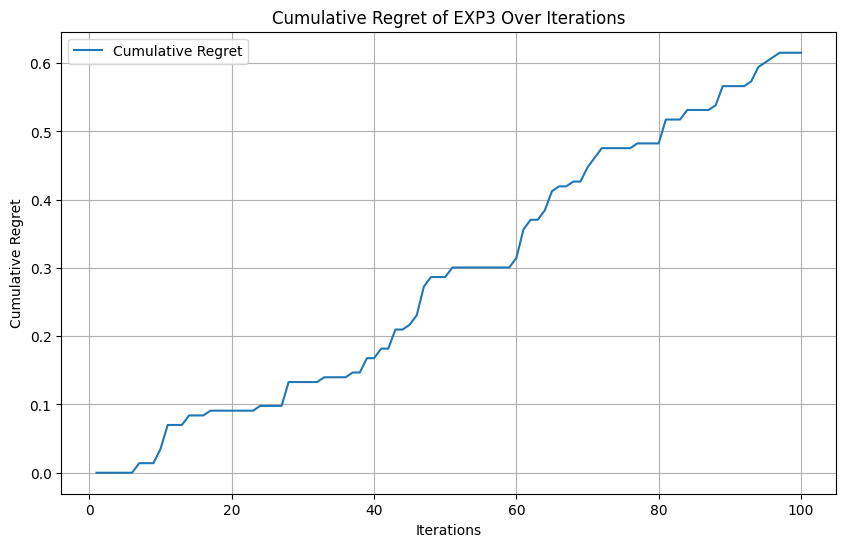

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the EXP3 algorithm class
class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
    
    def select_arm(self):
        total_weight = np.sum(self.weights)
        probabilities = (
            (1 - self.gamma) * (self.weights / total_weight) +
            (self.gamma / self.n_arms)
        )
        arm = np.random.choice(self.n_arms, p=probabilities)
        return arm, probabilities
    
    def update(self, chosen_arm, reward, probabilities):
        x = reward / probabilities[chosen_arm]
        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)

# Load the Titanic dataset
data = pd.read_csv('train.csv')

# Preprocessing steps
# Drop unnecessary columns
data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the possible values for each hyperparameter with expanded search space
hyperparameter_values = {
    'n_estimators': list(range(50, 301, 5)),  # [50, 55, 60, ..., 300]
    'max_depth': [None] + list(range(5, 100, 5)),  # [None, 5, 10, ..., 95]
    'min_samples_split': list(range(2, 50, 2)),  # [2, 4, 6, ..., 48]
    'max_features': ['sqrt', 'log2', None]
}

# Initialize current hyperparameter values (starting point)
current_params = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt'
}

# Train and evaluate the initial model
initial_model = RandomForestClassifier(
    n_estimators=current_params['n_estimators'],
    max_depth=current_params['max_depth'],
    min_samples_split=current_params['min_samples_split'],
    max_features=current_params['max_features'],
    random_state=42
)
initial_model.fit(X_train, y_train)

# Evaluate the initial model on the validation set
initial_y_pred = initial_model.predict(X_valid)
initial_accuracy = accuracy_score(y_valid, initial_y_pred)
print(f"Initial Model Accuracy (Before Tuning): {initial_accuracy:.4f}")

# Number of iterations for the hyperparameter tuning loop
n_iterations = 100

# Initialize the bandit algorithms for each hyperparameter
bandits = {}
for hp in hyperparameter_values:
    n_arms = len(hyperparameter_values[hp])
    bandits[hp] = {'algorithm': EXP3(n_arms)}

# Initialize the bandit algorithm for hyperparameter selection
hyperparameters = list(hyperparameter_values.keys())
n_hyperparameters = len(hyperparameters)
hyperparameter_bandit = EXP3(n_hyperparameters)

# Map hyperparameter indices to names
hyperparameter_indices = {idx: hp for idx, hp in enumerate(hyperparameters)}

# Track the best model performance and parameters
best_accuracy = initial_accuracy  # Start with the initial accuracy
best_params = current_params.copy()

# Initialize variables for cumulative regret tracking
cumulative_regret = []
best_possible_reward = initial_accuracy  # Start with the initial model's accuracy

# Hyperparameter tuning loop
for i in range(n_iterations):
    print(f"\nIteration {i+1}/{n_iterations}")
    
    # Select which hyperparameter to adjust using the hyperparameter bandit
    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()
    hp_to_adjust = hyperparameter_indices[hp_arm_index]
    
    # Select the value for the chosen hyperparameter using its bandit algorithm
    algorithm = bandits[hp_to_adjust]['algorithm']
    arm_index, probabilities = algorithm.select_arm()
    hp_value = hyperparameter_values[hp_to_adjust][arm_index]
    
    # Save the previous value to revert if necessary
    previous_value = current_params[hp_to_adjust]
    
    # Update the current parameters with the new value
    current_params[hp_to_adjust] = hp_value
    
    # Train the Random Forest model with the updated hyperparameters
    model = RandomForestClassifier(
        n_estimators=current_params['n_estimators'],
        max_depth=current_params['max_depth'],
        min_samples_split=current_params['min_samples_split'],
        max_features=current_params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    reward = accuracy  # Use accuracy as the reward

    # Update the best possible reward seen so far
    best_possible_reward = max(best_possible_reward, reward)
    
    # Calculate regret for this iteration
    iteration_regret = best_possible_reward - reward
    
    # Update cumulative regret
    if cumulative_regret:
        cumulative_regret.append(cumulative_regret[-1] + iteration_regret)
    else:
        cumulative_regret.append(iteration_regret)
    
    # Update the bandit algorithm for the chosen hyperparameter value
    algorithm.update(arm_index, reward, probabilities)
    
    # Update the hyperparameter selection bandit
    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)
    
    # Check if the new configuration is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = current_params.copy()
        print(f"New Best Accuracy: {best_accuracy:.4f} with Parameters: {best_params}")
    else:
        # If not better, revert the hyperparameter change
        current_params[hp_to_adjust] = previous_value

# After the tuning loop, print the best hyperparameters and accuracy
print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Plot cumulative regret
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), cumulative_regret, label="Cumulative Regret")
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of EXP3 Over Iterations")
plt.legend()
plt.grid()
plt.show()


Initial Model Accuracy (Before Tuning): 0.7762

Iteration 1/100
Predictions vs. Actual Values for Iteration 1:
     Actual  Predicted
0         1          1
1         1          1
2         0          0
3         1          1
4         0          0
..      ...        ...
138       0          0
139       1          1
140       0          1
141       1          1
142       1          1

[143 rows x 2 columns]
Adjusted Hyperparameter: max_depth
Selection Probabilities for Hyperparameters:
  Hyperparameter: n_estimators, Probability: 0.2500
  Hyperparameter: max_depth, Probability: 0.2500
  Hyperparameter: min_samples_split, Probability: 0.2500
  Hyperparameter: max_features, Probability: 0.2500
Selection Probabilities for 'max_depth':
  Value: None, Probability: 0.0500
  Value: 5, Probability: 0.0500
  Value: 10, Probability: 0.0500
  Value: 15, Probability: 0.0500
  Value: 20, Probability: 0.0500
  Value: 25, Probability: 0.0500
  Value: 30, Probability: 0.0500
  Value: 35, Probability:

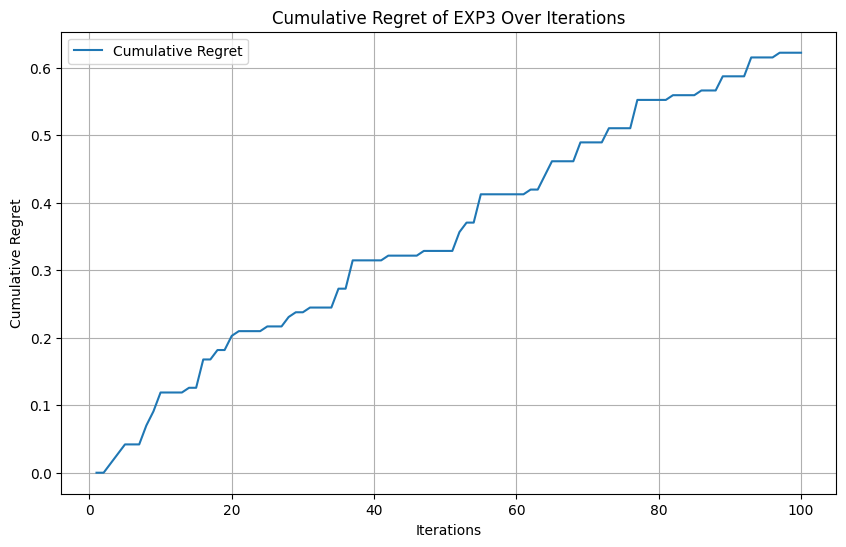

' \n\n# Load the test.csv file\ntest_data = pd.read_csv(\'test.csv\')\n\n# Preprocessing for the test data\n# Drop unnecessary columns\ntest_data = test_data.drop([\'Cabin\', \'Ticket\', \'Name\', \'PassengerId\'], axis=1, errors=\'ignore\')\n\n# Fill or drop missing values (depending on your training preprocessing)\ntest_data = test_data.dropna()\n\n# Encode categorical variables\nfor column in [\'Sex\', \'Embarked\']:\n    if column in test_data.columns:\n        if column in label_encoders:  # Use the same LabelEncoders from training\n            test_data[column] = label_encoders[column].transform(test_data[column])\n        else:\n            print(f"LabelEncoder not found for column \'{column}\'")\n\n# Ensure the test data matches the training feature set\nX_test = test_data\n\n# Predict using the final model\ntest_predictions = final_model.predict(X_test)\n\n# Display or save predictions\noutput = pd.DataFrame({\'Prediction\': test_predictions})\nprint(output)\n\n# Save predicti

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the EXP3 algorithm class
class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
    
    def select_arm(self):
        total_weight = np.sum(self.weights)
        probabilities = (
            (1 - self.gamma) * (self.weights / total_weight) +
            (self.gamma / self.n_arms)
        )
        arm = np.random.choice(self.n_arms, p=probabilities)
        return arm, probabilities
    
    def update(self, chosen_arm, reward, probabilities):
        x = reward / probabilities[chosen_arm]
        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)

# Load the Titanic dataset
data = pd.read_csv('train.csv')

# Preprocessing steps
# Drop unnecessary columns
data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print()

# Define the possible values for each hyperparameter with expanded search space
hyperparameter_values = {
    'n_estimators': list(range(50, 301, 5)),  # [50, 55, 60, ..., 300]
    'max_depth': [None] + list(range(5, 100, 5)),  # [None, 5, 10, ..., 95]
    'min_samples_split': list(range(2, 50, 2)),  # [2, 4, 6, ..., 48]
    'max_features': ['sqrt', 'log2', None]
}

# Initialize current hyperparameter values (starting point)
current_params = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt'
}

# **New Section: Train and Evaluate the Initial Model**
# Train the Random Forest model with the initial hyperparameters
initial_model = RandomForestClassifier(
    n_estimators=current_params['n_estimators'],
    max_depth=current_params['max_depth'],
    min_samples_split=current_params['min_samples_split'],
    max_features=current_params['max_features'],
    random_state=42
)
initial_model.fit(X_train, y_train)

# Evaluate the initial model on the validation set
initial_y_pred = initial_model.predict(X_valid)
initial_accuracy = accuracy_score(y_valid, initial_y_pred)
print(f"Initial Model Accuracy (Before Tuning): {initial_accuracy:.4f}")


#plotting the graph
cumulative_regret = []
best_possible_reward = initial_accuracy 


# Number of iterations for the hyperparameter tuning loop
n_iterations = 100

# Initialize the bandit algorithms for each hyperparameter
bandits = {}
for hp in hyperparameter_values:
    n_arms = len(hyperparameter_values[hp])
    bandits[hp] = {
        'algorithm': EXP3(n_arms)
    }

# Initialize the bandit algorithm for hyperparameter selection
hyperparameters = list(hyperparameter_values.keys())
n_hyperparameters = len(hyperparameters)
hyperparameter_bandit = EXP3(n_hyperparameters)

# Map hyperparameter indices to names
hyperparameter_indices = {idx: hp for idx, hp in enumerate(hyperparameters)}

# Track the best model performance and parameters
best_accuracy = initial_accuracy  # Start with the initial accuracy
best_params = current_params.copy()

# Hyperparameter tuning loop
for i in range(n_iterations):
    print(f"\nIteration {i+1}/{n_iterations}")
    
    # Select which hyperparameter to adjust using the hyperparameter bandit
    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()
    hp_to_adjust = hyperparameter_indices[hp_arm_index]
    
    # Completely random selection
    """ hp_to_adjust = np.random.choice(hyperparameters)
    hp_arm_index = hyperparameters.index(hp_to_adjust)

    # Simulate uniform probabilities for compatibility
    n_hyperparameters = len(hyperparameters)
    hp_probabilities = np.ones(n_hyperparameters) / n_hyperparameters
     """
    
    
    # Select the value for the chosen hyperparameter using its bandit algorithm
    algorithm = bandits[hp_to_adjust]['algorithm']
    arm_index, probabilities = algorithm.select_arm()
    hp_value = hyperparameter_values[hp_to_adjust][arm_index]
    
    # Save the previous value to revert if necessary
    previous_value = current_params[hp_to_adjust]
    
    # Update the current parameters with the new value
    current_params[hp_to_adjust] = hp_value
    
    # Train the Random Forest model with the updated hyperparameters
    model = RandomForestClassifier(
        n_estimators=current_params['n_estimators'],
        max_depth=current_params['max_depth'],
        min_samples_split=current_params['min_samples_split'],
        max_features=current_params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    reward = accuracy  # Use accuracy as the reward


    #track best possible reward for plotting
    best_possible_reward = max(best_possible_reward, reward)


    # Calculate regret for this iteration
    iteration_regret = best_possible_reward - reward


    # Update cumulative regret
    if cumulative_regret:
        cumulative_regret.append(cumulative_regret[-1] + iteration_regret)
    else:
        cumulative_regret.append(iteration_regret)

    comparison_df = pd.DataFrame({'Actual': y_valid.values, 'Predicted': y_pred})
    print(f"Predictions vs. Actual Values for Iteration {i+1}:")
    print(comparison_df.head(200))  # Display the first few rows
    
    # Update the bandit algorithm for the chosen hyperparameter value
    algorithm.update(arm_index, reward, probabilities)
    
    # Update the hyperparameter selection bandit
    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)
    
    # Print detailed output
    print(f"Adjusted Hyperparameter: {hp_to_adjust}")
    print(f"Selection Probabilities for Hyperparameters:")
    for idx, hp in enumerate(hyperparameters):
        print(f"  Hyperparameter: {hp}, Probability: {hp_probabilities[idx]:.4f}")
    print(f"Selection Probabilities for '{hp_to_adjust}':")
    for idx, val in enumerate(hyperparameter_values[hp_to_adjust]):
        print(f"  Value: {val}, Probability: {probabilities[idx]:.4f}")
    print(f"Chosen Value for '{hp_to_adjust}': {hp_value}")
    print(f"Reward (Accuracy): {accuracy:.4f}")
    print(f"Updated Weights for '{hp_to_adjust}': {algorithm.weights}")
    
    # Check if the new configuration is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = current_params.copy()
        print(f"New Best Accuracy: {best_accuracy:.4f} with Parameters: {best_params}")
    else:
        # If not better, revert the hyperparameter change
        current_params[hp_to_adjust] = previous_value

# After the tuning loop, print the best hyperparameters and accuracy
print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Train the final model with the best hyperparameters
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Make predictions on the validation set
final_predictions = final_model.predict(X_valid)

# Compare final predictions with actual values
final_comparison_df = pd.DataFrame({'Actual': y_valid.values, 'Predicted': final_predictions})
print("\nFinal Predictions vs. Actual Values:")
print(final_comparison_df.head(200))  # Display the first few rows


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), cumulative_regret, label="Cumulative Regret")
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of EXP3 Over Iterations")
plt.legend()
plt.grid()
plt.show()

""" 

# Load the test.csv file
test_data = pd.read_csv('test.csv')

# Preprocessing for the test data
# Drop unnecessary columns
test_data = test_data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, errors='ignore')

# Fill or drop missing values (depending on your training preprocessing)
test_data = test_data.dropna()

# Encode categorical variables
for column in ['Sex', 'Embarked']:
    if column in test_data.columns:
        if column in label_encoders:  # Use the same LabelEncoders from training
            test_data[column] = label_encoders[column].transform(test_data[column])
        else:
            print(f"LabelEncoder not found for column '{column}'")

# Ensure the test data matches the training feature set
X_test = test_data

# Predict using the final model
test_predictions = final_model.predict(X_test)

# Display or save predictions
output = pd.DataFrame({'Prediction': test_predictions})
print(output)

# Save predictions to a CSV file
output.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'") """


Initial Model Accuracy (Before Tuning): 0.7762

Iteration 1/100
Predictions vs. Actual Values for Iteration 1:
     Actual  Predicted
0         1          1
1         1          1
2         0          0
3         1          1
4         0          0
..      ...        ...
138       0          0
139       1          1
140       0          1
141       1          1
142       1          1

[143 rows x 2 columns]
Adjusted Hyperparameter: max_depth
Selection Probabilities for Hyperparameters:
  Hyperparameter: n_estimators, Probability: 0.2500
  Hyperparameter: max_depth, Probability: 0.2500
  Hyperparameter: min_samples_split, Probability: 0.2500
  Hyperparameter: max_features, Probability: 0.2500
Selection Probabilities for 'max_depth':
  Value: None, Probability: 0.0500
  Value: 5, Probability: 0.0500
  Value: 10, Probability: 0.0500
  Value: 15, Probability: 0.0500
  Value: 20, Probability: 0.0500
  Value: 25, Probability: 0.0500
  Value: 30, Probability: 0.0500
  Value: 35, Probability:

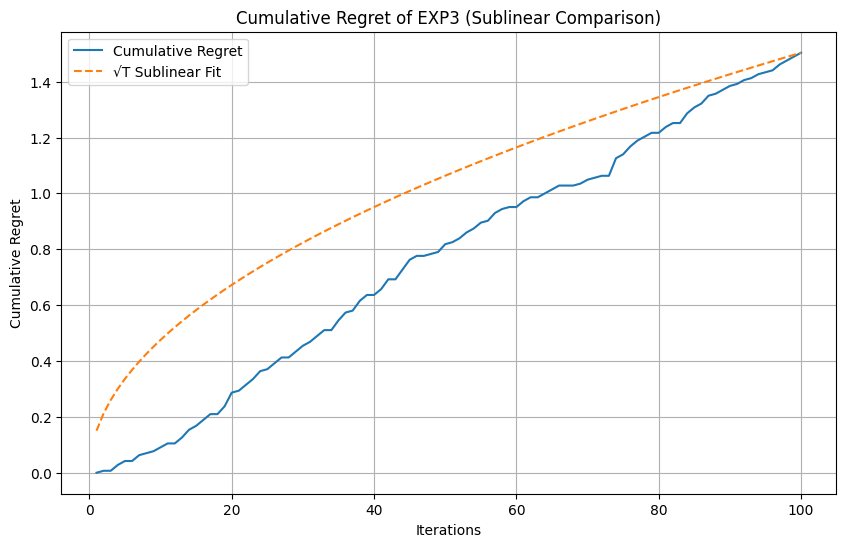

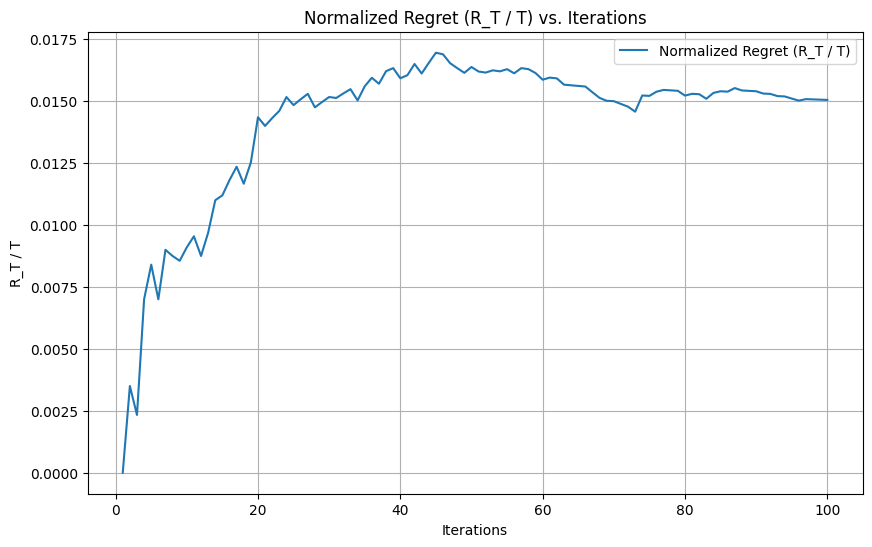

' \n\n# Load the test.csv file\ntest_data = pd.read_csv(\'test.csv\')\n\n# Preprocessing for the test data\n# Drop unnecessary columns\ntest_data = test_data.drop([\'Cabin\', \'Ticket\', \'Name\', \'PassengerId\'], axis=1, errors=\'ignore\')\n\n# Fill or drop missing values (depending on your training preprocessing)\ntest_data = test_data.dropna()\n\n# Encode categorical variables\nfor column in [\'Sex\', \'Embarked\']:\n    if column in test_data.columns:\n        if column in label_encoders:  # Use the same LabelEncoders from training\n            test_data[column] = label_encoders[column].transform(test_data[column])\n        else:\n            print(f"LabelEncoder not found for column \'{column}\'")\n\n# Ensure the test data matches the training feature set\nX_test = test_data\n\n# Predict using the final model\ntest_predictions = final_model.predict(X_test)\n\n# Display or save predictions\noutput = pd.DataFrame({\'Prediction\': test_predictions})\nprint(output)\n\n# Save predicti

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the EXP3 algorithm class
class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
    
    def select_arm(self):
        total_weight = np.sum(self.weights)
        probabilities = (
            (1 - self.gamma) * (self.weights / total_weight) +
            (self.gamma / self.n_arms)
        )
        arm = np.random.choice(self.n_arms, p=probabilities)
        return arm, probabilities
    
    def update(self, chosen_arm, reward, probabilities):
        x = reward / probabilities[chosen_arm]
        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)

# Load the Titanic dataset
data = pd.read_csv('train.csv')

# Preprocessing steps
# Drop unnecessary columns
data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print()

# Define the possible values for each hyperparameter with expanded search space
hyperparameter_values = {
    'n_estimators': list(range(50, 301, 5)),  # [50, 55, 60, ..., 300]
    'max_depth': [None] + list(range(5, 100, 5)),  # [None, 5, 10, ..., 95]
    'min_samples_split': list(range(2, 50, 2)),  # [2, 4, 6, ..., 48]
    'max_features': ['sqrt', 'log2', None]
}

# Initialize current hyperparameter values (starting point)
current_params = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt'
}

# **New Section: Train and Evaluate the Initial Model**
# Train the Random Forest model with the initial hyperparameters
initial_model = RandomForestClassifier(
    n_estimators=current_params['n_estimators'],
    max_depth=current_params['max_depth'],
    min_samples_split=current_params['min_samples_split'],
    max_features=current_params['max_features'],
    random_state=42
)
initial_model.fit(X_train, y_train)

# Evaluate the initial model on the validation set
initial_y_pred = initial_model.predict(X_valid)
initial_accuracy = accuracy_score(y_valid, initial_y_pred)
print(f"Initial Model Accuracy (Before Tuning): {initial_accuracy:.4f}")


#plotting the graph
cumulative_regret = []
best_possible_reward = initial_accuracy 


# Number of iterations for the hyperparameter tuning loop
n_iterations = 100

# Initialize the bandit algorithms for each hyperparameter
bandits = {}
for hp in hyperparameter_values:
    n_arms = len(hyperparameter_values[hp])
    bandits[hp] = {
        'algorithm': EXP3(n_arms)
    }

# Initialize the bandit algorithm for hyperparameter selection
hyperparameters = list(hyperparameter_values.keys())
n_hyperparameters = len(hyperparameters)
hyperparameter_bandit = EXP3(n_hyperparameters)

# Map hyperparameter indices to names
hyperparameter_indices = {idx: hp for idx, hp in enumerate(hyperparameters)}

# Track the best model performance and parameters
best_accuracy = initial_accuracy  # Start with the initial accuracy
best_params = current_params.copy()

# Hyperparameter tuning loop
for i in range(n_iterations):
    print(f"\nIteration {i+1}/{n_iterations}")
    
    # Select which hyperparameter to adjust using the hyperparameter bandit
    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()
    hp_to_adjust = hyperparameter_indices[hp_arm_index]
    
    # Completely random selection
    """ hp_to_adjust = np.random.choice(hyperparameters)
    hp_arm_index = hyperparameters.index(hp_to_adjust)

    # Simulate uniform probabilities for compatibility
    n_hyperparameters = len(hyperparameters)
    hp_probabilities = np.ones(n_hyperparameters) / n_hyperparameters
     """
    
    
    # Select the value for the chosen hyperparameter using its bandit algorithm
    algorithm = bandits[hp_to_adjust]['algorithm']
    arm_index, probabilities = algorithm.select_arm()
    hp_value = hyperparameter_values[hp_to_adjust][arm_index]
    
    # Save the previous value to revert if necessary
    previous_value = current_params[hp_to_adjust]
    
    # Update the current parameters with the new value
    current_params[hp_to_adjust] = hp_value
    
    # Train the Random Forest model with the updated hyperparameters
    model = RandomForestClassifier(
        n_estimators=current_params['n_estimators'],
        max_depth=current_params['max_depth'],
        min_samples_split=current_params['min_samples_split'],
        max_features=current_params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    reward = accuracy  # Use accuracy as the reward


    #track best possible reward for plotting
    best_possible_reward = max(best_possible_reward, reward)


    # Calculate regret for this iteration
    iteration_regret = best_possible_reward - reward


    # Update cumulative regret
    if cumulative_regret:
        cumulative_regret.append(cumulative_regret[-1] + iteration_regret)
    else:
        cumulative_regret.append(iteration_regret)

    comparison_df = pd.DataFrame({'Actual': y_valid.values, 'Predicted': y_pred})
    print(f"Predictions vs. Actual Values for Iteration {i+1}:")
    print(comparison_df.head(200))  # Display the first few rows
    
    # Update the bandit algorithm for the chosen hyperparameter value
    algorithm.update(arm_index, reward, probabilities)
    
    # Update the hyperparameter selection bandit
    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)
    
    # Print detailed output
    print(f"Adjusted Hyperparameter: {hp_to_adjust}")
    print(f"Selection Probabilities for Hyperparameters:")
    for idx, hp in enumerate(hyperparameters):
        print(f"  Hyperparameter: {hp}, Probability: {hp_probabilities[idx]:.4f}")
    print(f"Selection Probabilities for '{hp_to_adjust}':")
    for idx, val in enumerate(hyperparameter_values[hp_to_adjust]):
        print(f"  Value: {val}, Probability: {probabilities[idx]:.4f}")
    print(f"Chosen Value for '{hp_to_adjust}': {hp_value}")
    print(f"Reward (Accuracy): {accuracy:.4f}")
    print(f"Updated Weights for '{hp_to_adjust}': {algorithm.weights}")
    
    # Check if the new configuration is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = current_params.copy()
        print(f"New Best Accuracy: {best_accuracy:.4f} with Parameters: {best_params}")
    else:
        # If not better, revert the hyperparameter change
        current_params[hp_to_adjust] = previous_value

# After the tuning loop, print the best hyperparameters and accuracy
print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Train the final model with the best hyperparameters
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Make predictions on the validation set
final_predictions = final_model.predict(X_valid)

# Compare final predictions with actual values
final_comparison_df = pd.DataFrame({'Actual': y_valid.values, 'Predicted': final_predictions})
print("\nFinal Predictions vs. Actual Values:")
print(final_comparison_df.head(200))  # Display the first few rows


# Plot cumulative regret and compare it with sublinear growth (sqrt(T))
sqrt_fit = np.sqrt(np.arange(1, n_iterations + 1)) * (cumulative_regret[-1] / np.sqrt(n_iterations))

plt.figure(figsize=(10, 6))

# Plot cumulative regret
plt.plot(range(1, n_iterations + 1), cumulative_regret, label="Cumulative Regret")
plt.plot(range(1, n_iterations + 1), sqrt_fit, linestyle='--', label="√T Sublinear Fit")

# Add labels and legend
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of EXP3 (Sublinear Comparison)")
plt.legend()
plt.grid()
plt.show()

# Plot normalized regret (R_T / T) to show that it decreases over iterations
normalized_regret = [reg / t for reg, t in zip(cumulative_regret, range(1, n_iterations + 1))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), normalized_regret, label="Normalized Regret (R_T / T)")
plt.xlabel("Iterations")
plt.ylabel("R_T / T")
plt.title("Normalized Regret (R_T / T) vs. Iterations")
plt.legend()
plt.grid()
plt.show()

""" 

# Load the test.csv file
test_data = pd.read_csv('test.csv')

# Preprocessing for the test data
# Drop unnecessary columns
test_data = test_data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, errors='ignore')

# Fill or drop missing values (depending on your training preprocessing)
test_data = test_data.dropna()

# Encode categorical variables
for column in ['Sex', 'Embarked']:
    if column in test_data.columns:
        if column in label_encoders:  # Use the same LabelEncoders from training
            test_data[column] = label_encoders[column].transform(test_data[column])
        else:
            print(f"LabelEncoder not found for column '{column}'")

# Ensure the test data matches the training feature set
X_test = test_data

# Predict using the final model
test_predictions = final_model.predict(X_test)

# Display or save predictions
output = pd.DataFrame({'Prediction': test_predictions})
print(output)

# Save predictions to a CSV file
output.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'") """


Initial Model Accuracy (Before Tuning): 0.7762

Iteration 1/20
Predictions vs. Actual Values for Iteration 1:
     Actual  Predicted
0         1          1
1         1          1
2         0          0
3         1          1
4         0          0
..      ...        ...
138       0          0
139       1          1
140       0          1
141       1          1
142       1          1

[143 rows x 2 columns]
Adjusted Hyperparameter: max_depth
Selection Probabilities for Hyperparameters:
  Hyperparameter: n_estimators, Probability: 0.2500
  Hyperparameter: max_depth, Probability: 0.2500
  Hyperparameter: min_samples_split, Probability: 0.2500
  Hyperparameter: max_features, Probability: 0.2500
Selection Probabilities for 'max_depth':
  Value: None, Probability: 0.0500
  Value: 5, Probability: 0.0500
  Value: 10, Probability: 0.0500
  Value: 15, Probability: 0.0500
  Value: 20, Probability: 0.0500
  Value: 25, Probability: 0.0500
  Value: 30, Probability: 0.0500
  Value: 35, Probability: 

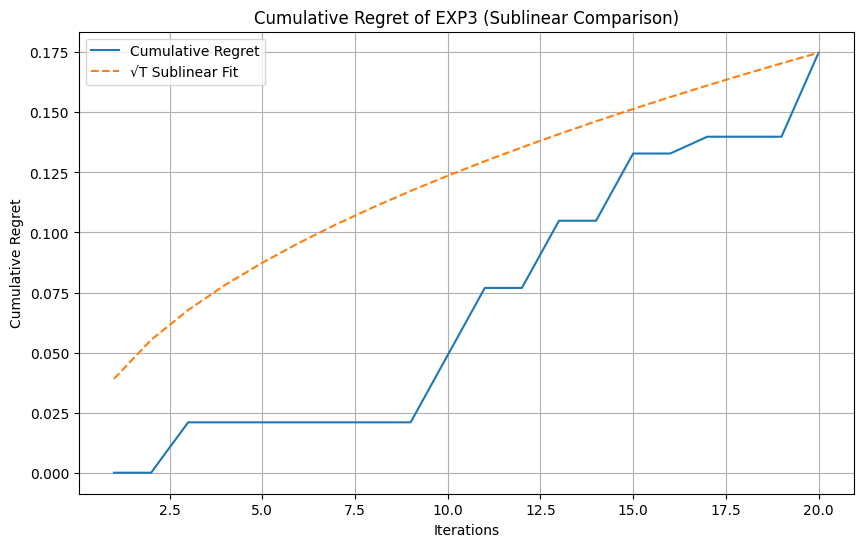

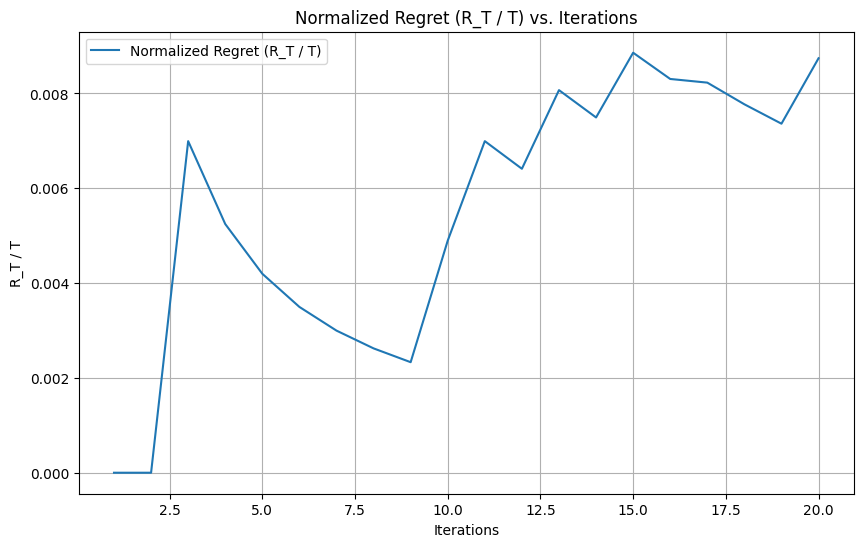

' \n\n# Load the test.csv file\ntest_data = pd.read_csv(\'test.csv\')\n\n# Preprocessing for the test data\n# Drop unnecessary columns\ntest_data = test_data.drop([\'Cabin\', \'Ticket\', \'Name\', \'PassengerId\'], axis=1, errors=\'ignore\')\n\n# Fill or drop missing values (depending on your training preprocessing)\ntest_data = test_data.dropna()\n\n# Encode categorical variables\nfor column in [\'Sex\', \'Embarked\']:\n    if column in test_data.columns:\n        if column in label_encoders:  # Use the same LabelEncoders from training\n            test_data[column] = label_encoders[column].transform(test_data[column])\n        else:\n            print(f"LabelEncoder not found for column \'{column}\'")\n\n# Ensure the test data matches the training feature set\nX_test = test_data\n\n# Predict using the final model\ntest_predictions = final_model.predict(X_test)\n\n# Display or save predictions\noutput = pd.DataFrame({\'Prediction\': test_predictions})\nprint(output)\n\n# Save predicti

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the EXP3 algorithm class
class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
    
    def select_arm(self):
        total_weight = np.sum(self.weights)
        probabilities = (
            (1 - self.gamma) * (self.weights / total_weight) +
            (self.gamma / self.n_arms)
        )
        arm = np.random.choice(self.n_arms, p=probabilities)
        return arm, probabilities
    
    def update(self, chosen_arm, reward, probabilities):
        x = reward / probabilities[chosen_arm]
        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)

# Load the Titanic dataset
data = pd.read_csv('train.csv')

# Preprocessing steps
# Drop unnecessary columns
data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print()

# Define the possible values for each hyperparameter with expanded search space
hyperparameter_values = {
    'n_estimators': list(range(50, 301, 5)),  # [50, 55, 60, ..., 300]
    'max_depth': [None] + list(range(5, 100, 5)),  # [None, 5, 10, ..., 95]
    'min_samples_split': list(range(2, 50, 2)),  # [2, 4, 6, ..., 48]
    'max_features': ['sqrt', 'log2', None]
}

# Initialize current hyperparameter values (starting point)
current_params = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt'
}

# **New Section: Train and Evaluate the Initial Model**
# Train the Random Forest model with the initial hyperparameters
initial_model = RandomForestClassifier(
    n_estimators=current_params['n_estimators'],
    max_depth=current_params['max_depth'],
    min_samples_split=current_params['min_samples_split'],
    max_features=current_params['max_features'],
    random_state=42
)
initial_model.fit(X_train, y_train)

# Evaluate the initial model on the validation set
initial_y_pred = initial_model.predict(X_valid)
initial_accuracy = accuracy_score(y_valid, initial_y_pred)
print(f"Initial Model Accuracy (Before Tuning): {initial_accuracy:.4f}")


#plotting the graph
cumulative_regret = []
best_possible_reward = initial_accuracy 


# Number of iterations for the hyperparameter tuning loop
n_iterations = 20

# Initialize the bandit algorithms for each hyperparameter
bandits = {}
for hp in hyperparameter_values:
    n_arms = len(hyperparameter_values[hp])
    bandits[hp] = {
        'algorithm': EXP3(n_arms)
    }

# Initialize the bandit algorithm for hyperparameter selection
hyperparameters = list(hyperparameter_values.keys())
n_hyperparameters = len(hyperparameters)
hyperparameter_bandit = EXP3(n_hyperparameters)

# Map hyperparameter indices to names
hyperparameter_indices = {idx: hp for idx, hp in enumerate(hyperparameters)}

# Track the best model performance and parameters
best_accuracy = initial_accuracy  # Start with the initial accuracy
best_params = current_params.copy()

# Hyperparameter tuning loop
for i in range(n_iterations):
    print(f"\nIteration {i+1}/{n_iterations}")
    
    # Select which hyperparameter to adjust using the hyperparameter bandit
    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()
    hp_to_adjust = hyperparameter_indices[hp_arm_index]
    
    # Completely random selection
    """ hp_to_adjust = np.random.choice(hyperparameters)
    hp_arm_index = hyperparameters.index(hp_to_adjust)

    # Simulate uniform probabilities for compatibility
    n_hyperparameters = len(hyperparameters)
    hp_probabilities = np.ones(n_hyperparameters) / n_hyperparameters
     """
    
    
    # Select the value for the chosen hyperparameter using its bandit algorithm
    algorithm = bandits[hp_to_adjust]['algorithm']
    arm_index, probabilities = algorithm.select_arm()
    hp_value = hyperparameter_values[hp_to_adjust][arm_index]
    
    # Save the previous value to revert if necessary
    previous_value = current_params[hp_to_adjust]
    
    # Update the current parameters with the new value
    current_params[hp_to_adjust] = hp_value
    
    # Train the Random Forest model with the updated hyperparameters
    model = RandomForestClassifier(
        n_estimators=current_params['n_estimators'],
        max_depth=current_params['max_depth'],
        min_samples_split=current_params['min_samples_split'],
        max_features=current_params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    reward = accuracy  # Use accuracy as the reward


    #track best possible reward for plotting
    best_possible_reward = max(best_possible_reward, reward)


    # Calculate regret for this iteration
    iteration_regret = best_possible_reward - reward


    # Update cumulative regret
    if cumulative_regret:
        cumulative_regret.append(cumulative_regret[-1] + iteration_regret)
    else:
        cumulative_regret.append(iteration_regret)

    comparison_df = pd.DataFrame({'Actual': y_valid.values, 'Predicted': y_pred})
    print(f"Predictions vs. Actual Values for Iteration {i+1}:")
    print(comparison_df.head(200))  # Display the first few rows
    
    # Update the bandit algorithm for the chosen hyperparameter value
    algorithm.update(arm_index, reward, probabilities)
    
    # Update the hyperparameter selection bandit
    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)
    
    # Print detailed output
    print(f"Adjusted Hyperparameter: {hp_to_adjust}")
    print(f"Selection Probabilities for Hyperparameters:")
    for idx, hp in enumerate(hyperparameters):
        print(f"  Hyperparameter: {hp}, Probability: {hp_probabilities[idx]:.4f}")
    print(f"Selection Probabilities for '{hp_to_adjust}':")
    for idx, val in enumerate(hyperparameter_values[hp_to_adjust]):
        print(f"  Value: {val}, Probability: {probabilities[idx]:.4f}")
    print(f"Chosen Value for '{hp_to_adjust}': {hp_value}")
    print(f"Reward (Accuracy): {accuracy:.4f}")
    print(f"Updated Weights for '{hp_to_adjust}': {algorithm.weights}")
    
    # Check if the new configuration is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = current_params.copy()
        print(f"New Best Accuracy: {best_accuracy:.4f} with Parameters: {best_params}")
    else:
        # If not better, revert the hyperparameter change
        current_params[hp_to_adjust] = previous_value

# After the tuning loop, print the best hyperparameters and accuracy
print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Train the final model with the best hyperparameters
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Make predictions on the validation set
final_predictions = final_model.predict(X_valid)

# Compare final predictions with actual values
final_comparison_df = pd.DataFrame({'Actual': y_valid.values, 'Predicted': final_predictions})
print("\nFinal Predictions vs. Actual Values:")
print(final_comparison_df.head(200))  # Display the first few rows


# Plot cumulative regret and compare it with sublinear growth (sqrt(T))
sqrt_fit = np.sqrt(np.arange(1, n_iterations + 1)) * (cumulative_regret[-1] / np.sqrt(n_iterations))

plt.figure(figsize=(10, 6))

# Plot cumulative regret
plt.plot(range(1, n_iterations + 1), cumulative_regret, label="Cumulative Regret")
plt.plot(range(1, n_iterations + 1), sqrt_fit, linestyle='--', label="√T Sublinear Fit")

# Add labels and legend
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of EXP3 (Sublinear Comparison)")
plt.legend()
plt.grid()
plt.show()

# Plot normalized regret (R_T / T) to show that it decreases over iterations
normalized_regret = [reg / t for reg, t in zip(cumulative_regret, range(1, n_iterations + 1))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), normalized_regret, label="Normalized Regret (R_T / T)")
plt.xlabel("Iterations")
plt.ylabel("R_T / T")
plt.title("Normalized Regret (R_T / T) vs. Iterations")
plt.legend()
plt.grid()
plt.show()

""" 

# Load the test.csv file
test_data = pd.read_csv('test.csv')

# Preprocessing for the test data
# Drop unnecessary columns
test_data = test_data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, errors='ignore')

# Fill or drop missing values (depending on your training preprocessing)
test_data = test_data.dropna()

# Encode categorical variables
for column in ['Sex', 'Embarked']:
    if column in test_data.columns:
        if column in label_encoders:  # Use the same LabelEncoders from training
            test_data[column] = label_encoders[column].transform(test_data[column])
        else:
            print(f"LabelEncoder not found for column '{column}'")

# Ensure the test data matches the training feature set
X_test = test_data

# Predict using the final model
test_predictions = final_model.predict(X_test)

# Display or save predictions
output = pd.DataFrame({'Prediction': test_predictions})
print(output)

# Save predictions to a CSV file
output.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'") """